<a href="https://colab.research.google.com/github/N1colasFD/Unir_CODES/blob/main/Ames_Housing_Pipeline_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 🏠 Ames Housing: EDA + Árboles y Random Forest (Regresión y Clasificación)

**Objetivo**: reproducir el flujo solicitado en el laboratorio con un **pipeline basado en funciones**, simple y claro.

**Cómo usar en Colab**  
1. Sube este notebook a tu Google Drive y ábrelo con Google Colab.  
2. En la sección **Datos**, sube `housing_train.csv` (o monta tu Drive y apunta la ruta).  
3. Ejecuta las celdas en orden (Ctrl+F9 para todo).

> Si no encuentra el CSV automáticamente, el notebook te pedirá **subirlo** con un diálogo.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

from pathlib import Path
import io, os, json, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, confusion_matrix

RANDOM_STATE = 42
plt.rcParams.update({"figure.figsize": (8, 5)})


In [ ]:
# --- RMSE compatible con cualquier versión de scikit-learn ---
def compute_rmse(y_true, y_pred):
    # 1) si existe root_mean_squared_error, úsalo
    try:
        from sklearn.metrics import root_mean_squared_error
        return float(root_mean_squared_error(y_true, y_pred))
    except Exception:
        pass
    # 2) si MSE acepta squared=False, úsalo
    try:
        from sklearn.metrics import mean_squared_error
        return float(mean_squared_error(y_true, y_pred, squared=False))
    except TypeError:
        # 3) fallback: sqrt(MSE)
        from sklearn.metrics import mean_squared_error
        return float(mean_squared_error(y_true, y_pred) ** 0.5)

In [ ]:

def load_data_with_fallback(default_path: str = "/content/drive/MyDrive/UNIR/Aprendizaje automático (COEINTAR) - Julio 2025 - PER 13510/Trabajos/Laboratorio Árboles y random forest para regresión y clasificación/mia05_lab/housing_train.csv") -> pd.DataFrame:
    path = Path(default_path)
    if path.exists():
        print(f"Leyendo CSV desde: {path.resolve()}")
        return pd.read_csv(path)
    try:
        from google.colab import files  # type: ignore
        print("No se encontró el CSV en el directorio actual.")
        print("Selecciona tu archivo CSV (por ejemplo, 'housing_train.csv')...")
        uploaded = files.upload()
        for fname, data in uploaded.items():
            if fname.lower().endswith('.csv'):
                print(f"Leyendo '{fname}' desde upload...")
                import io
                return pd.read_csv(io.BytesIO(data))
        raise FileNotFoundError("No se subió ningún .csv")
    except Exception as e:
        raise FileNotFoundError("No se encontró el CSV y no fue posible abrir el diálogo de subida. "
                                "Asegúrate de colocar 'housing_train.csv' en el mismo directorio "
                                "o monta Google Drive y ajusta la ruta.") from e

In [ ]:
def overview_table(df: pd.DataFrame) -> pd.DataFrame:
    n = len(df)
    rows = []
    for c in df.columns:
        rows.append({
            "col": c,
            "dtype": str(df[c].dtype),
            "n_missing": int(df[c].isna().sum()),
            "pct_missing": round(100*df[c].isna().mean(), 2),
            "n_unique": int(df[c].nunique(dropna=True))
        })
    return pd.DataFrame(rows).sort_values("col")

def numeric_stats(df: pd.DataFrame) -> pd.DataFrame:
    return df.select_dtypes(include=[np.number]).describe().T

def categorical_summary(df: pd.DataFrame) -> pd.DataFrame:
    cats = df.select_dtypes(include=["object","category"]).columns.tolist()
    out = []
    for c in cats:
        vc = df[c].value_counts()
        top = f"{vc.index[0]} ({vc.iloc[0]})" if len(vc) else ""
        out.append({"col": c, "n_unique": int(df[c].nunique()), "top": top})
    return pd.DataFrame(out).sort_values("col")

def missing_summary(df: pd.DataFrame) -> pd.DataFrame:
    ms = df.isna().sum().to_frame("n_missing")
    ms["pct_missing"] = (ms["n_missing"]/len(df)*100).round(2)
    return ms[ms["n_missing"]>0].sort_values("pct_missing", ascending=False)

def plot_corr(df: pd.DataFrame, limit=30):
    num = df.select_dtypes(include=[np.number]).copy()
    if num.empty:
        print("No hay columnas numéricas para correlación.")
        return
    corr = num.corr(numeric_only=True)
    if "SalePrice" in corr.columns:
        order = corr["SalePrice"].abs().sort_values(ascending=False).index[:limit]
        corr = corr.loc[order, order]
    plt.figure(figsize=(10,8))
    im = plt.imshow(corr, interpolation="nearest", aspect="auto")
    plt.title("Matriz de correlación (top numéricas)")
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=7)
    plt.yticks(range(len(corr.index)), corr.index, fontsize=7)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()


In [ ]:

def preprocessor_for(X: pd.DataFrame) -> ColumnTransformer:
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = X.select_dtypes(include=["object","category","bool"]).columns.tolist()
    numeric = Pipeline([("imp", SimpleImputer(strategy="median"))])
    categor = Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                        ("oh", OneHotEncoder(handle_unknown="ignore"))])
    return ColumnTransformer([("num", numeric, num_cols),
                              ("cat", categor, cat_cols)])

In [ ]:

def do_regression(X: pd.DataFrame, y: pd.Series) -> dict:
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
    prep = preprocessor_for(Xtr)
    tree = Pipeline([("prep", prep), ("model", DecisionTreeRegressor(random_state=RANDOM_STATE))])
    rf   = Pipeline([("prep", prep), ("model", RandomForestRegressor(n_estimators=200,
                                                                     random_state=RANDOM_STATE,
                                                                     n_jobs=-1))])
    tree.fit(Xtr, ytr); rf.fit(Xtr, ytr)
    p_tree = tree.predict(Xte); p_rf = rf.predict(Xte)
    rmse_tree = compute_rmse(yte, p_tree)
    rmse_rf   = compute_rmse(yte, p_rf)
    print("RMSE Árbol:", f"{rmse_tree:,.2f}")
    print("RMSE Random Forest:", f"{rmse_rf:,.2f}")
    return {"RMSE_Tree": float(rmse_tree), "RMSE_RF": float(rmse_rf)}

In [ ]:

def groups_from_prices(y: pd.Series) -> pd.Series:
    bins = [-np.inf, 100000, 500000, np.inf]
    labels = [1,2,3]
    return pd.cut(y, bins=bins, labels=labels, right=True).astype(int)

def do_classification(X: pd.DataFrame, y: pd.Series) -> dict:
    yg = groups_from_prices(y)
    vc = yg.value_counts()
    strat = yg if (vc.min() >= 2) else None
    Xtr, Xte, ytr, yte = train_test_split(X, yg, test_size=0.2, random_state=RANDOM_STATE, stratify=strat)
    prep = preprocessor_for(Xtr)
    tree = Pipeline([("prep", prep), ("model", DecisionTreeClassifier(random_state=RANDOM_STATE))])
    rf   = Pipeline([("prep", prep), ("model", RandomForestClassifier(n_estimators=200,
                                                                      random_state=RANDOM_STATE,
                                                                      n_jobs=-1))])
    tree.fit(Xtr, ytr); rf.fit(Xtr, ytr)
    pt = tree.predict(Xte); pr = rf.predict(Xte)
    cm_t = confusion_matrix(yte, pt, labels=[1,2,3])
    cm_r = confusion_matrix(yte, pr, labels=[1,2,3])
    def acc_per_class(cm):
        out = {}
        for i, cls in enumerate([1,2,3]):
            total = cm[i,:].sum()
            out[cls] = float(cm[i,i]/total) if total>0 else float("nan")
        return out
    print("Matriz de confusión Árbol (filas=verdad, cols=pred):\n", cm_t)
    print("Exactitud por clase Árbol:", acc_per_class(cm_t))
    print("\nMatriz de confusión RF (filas=verdad, cols=pred):\n", cm_r)
    print("Exactitud por clase RF:", acc_per_class(cm_r))
    return {"cm_tree": cm_t.tolist(), "acc_tree": acc_per_class(cm_t),
            "cm_rf": cm_r.tolist(), "acc_rf": acc_per_class(cm_r)}


In [ ]:

def safe_top_k_correlations(df: pd.DataFrame, target="SalePrice", k=10):
    if target not in df.columns:
        print(f"Columna objetivo '{target}' no existe en el DataFrame.")
        return
    y = pd.to_numeric(df[target], errors="coerce")
    if y.notna().sum() < 3:
        print("Muy pocos valores válidos en la columna objetivo para calcular correlaciones.")
        return
    num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c != target]
    if not num_cols:
        print("No hay columnas numéricas (aparte del objetivo) para correlacionar.")
        return
    corrs = {}
    for c in num_cols:
        s = pd.to_numeric(df[c], errors="coerce")
        m = pd.concat([y, s], axis=1).dropna()
        if len(m) >= 3:
            corrs[c] = m.corr().iloc[0,1]
    if not corrs:
        print("No se pudieron calcular correlaciones (faltan datos).")
        return
    s = pd.Series(corrs).abs().sort_values(ascending=False).head(k)
    display(pd.DataFrame({f"|corr| con {target}": s}))

In [ ]:
def rmse(y_true, y_pred):
    # usa 'squared=False' si existe; si no, calcula la raíz manualmente
    try:
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        return mean_squared_error(y_true, y_pred) ** 0.5

Leyendo CSV desde: /content/drive/MyDrive/UNIR/Aprendizaje automático (COEINTAR) - Julio 2025 - PER 13510/Trabajos/Laboratorio Árboles y random forest para regresión y clasificación/mia05_lab/housing_train.csv
Shape: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


,col,dtype,n_missing,pct_missing,n_unique
43,1stFlrSF,int64,0,0.00,753
44,2ndFlrSF,int64,0,0.00,417
69,3SsnPorch,int64,0,0.00,20
6,Alley,object,1369,93.77,2
51,BedroomAbvGr,int64,0,0.00,8
...,...,...,...,...,...
9,Utilities,object,0,0.00,2
66,WoodDeckSF,int64,0,0.00,274
19,YearBuilt,int64,0,0.00,112
20,YearRemodAdd,int64,0,0.00,61


,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.50,421.61,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.90,42.30,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.05,24.28,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.83,9981.26,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.10,1.38,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.58,1.11,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.27,30.20,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.87,20.65,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.69,181.07,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.64,456.10,0.0,0.00,383.5,712.25,5644.0


,col,n_unique,top
2,Alley,2,Grvl (50)
11,BldgType,5,1Fam (1220)
22,BsmtCond,4,TA (1311)
23,BsmtExposure,4,No (953)
24,BsmtFinType1,6,Unf (430)
25,BsmtFinType2,6,Unf (1256)
21,BsmtQual,4,TA (649)
28,CentralAir,2,Y (1365)
9,Condition1,9,Norm (1260)
10,Condition2,8,Norm (1445)


,n_missing,pct_missing
PoolQC,1453,99.52
MiscFeature,1406,96.30
Alley,1369,93.77
Fence,1179,80.75
MasVnrType,872,59.73
FireplaceQu,690,47.26
LotFrontage,259,17.74
GarageType,81,5.55
GarageYrBlt,81,5.55
GarageFinish,81,5.55


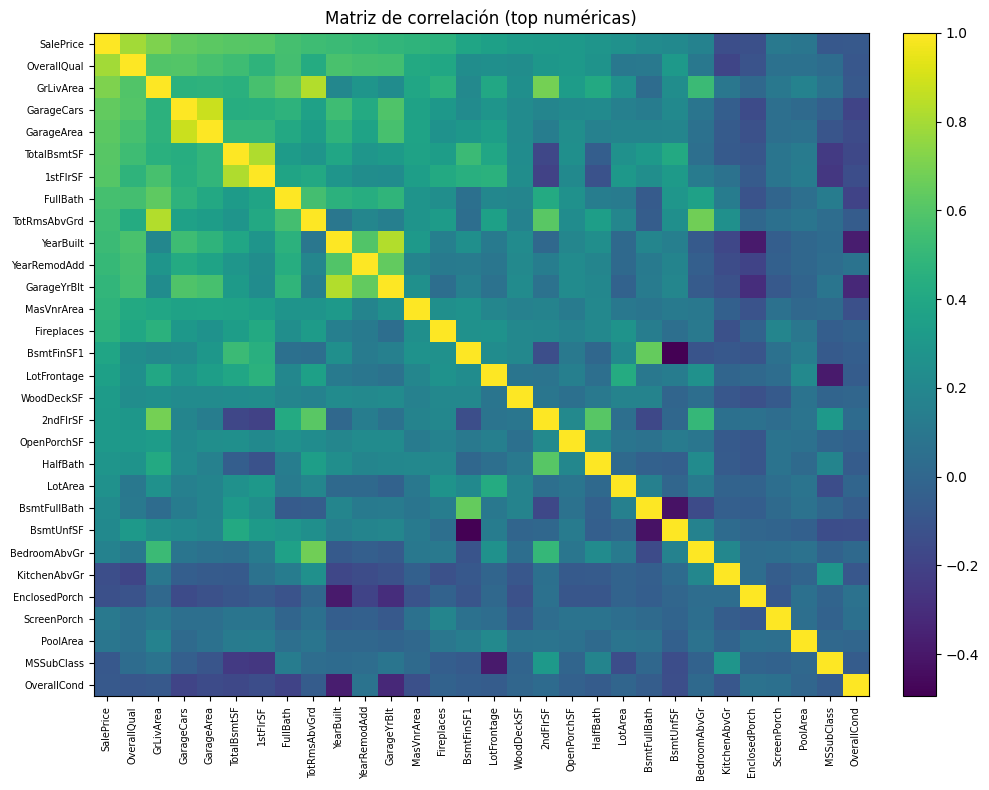


=== REGRESIÓN ===
RMSE Árbol: 41,191.30
RMSE Random Forest: 28,495.23

=== CLASIFICACIÓN ===
Matriz de confusión Árbol (filas=verdad, cols=pred):
 [[ 14  11   0]
 [ 13 252   0]
 [  0   2   0]]
Exactitud por clase Árbol: {1: 0.56, 2: 0.9509433962264151, 3: 0.0}

Matriz de confusión RF (filas=verdad, cols=pred):
 [[ 12  13   0]
 [  0 265   0]
 [  0   2   0]]
Exactitud por clase RF: {1: 0.48, 2: 1.0, 3: 0.0}

=== TOP 10 |CORR| CON SalePrice (robusto) ===


,|corr| con SalePrice
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897
YearRemodAdd,0.507101


In [ ]:

df = load_data_with_fallback("/content/drive/MyDrive/UNIR/Aprendizaje automático (COEINTAR) - Julio 2025 - PER 13510/Trabajos/Laboratorio Árboles y random forest para regresión y clasificación/mia05_lab/housing_train.csv")
print("Shape:", df.shape)
display(df.head())

display(overview_table(df))
display(numeric_stats(df).round(2))
cat_sum = categorical_summary(df)
if not cat_sum.empty:
    display(cat_sum)
miss = missing_summary(df)
if not miss.empty:
    display(miss)

plot_corr(df, limit=30)

if "Id" in df.columns:
    X = df.drop(columns=["SalePrice", "Id"])
else:
    X = df.drop(columns=["SalePrice"])
y = df["SalePrice"].copy()

print("\n=== REGRESIÓN ===")
reg_metrics = do_regression(X, y)

print("\n=== CLASIFICACIÓN ===")
clf_metrics = do_classification(X, y)

print("\n=== TOP 10 |CORR| CON SalePrice (robusto) ===")
safe_top_k_correlations(df, target="SalePrice", k=10)
